In [14]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd
import matplotlib.pyplot as plt
import threading
import re
import numpy as np
import matplotlib.cm as cm

## Scrapper class

In [15]:
class Scrapper():
    def __init__(self) -> None:
        options = Options()
        options.headless = False  # Run in normal mode for debugging
        service = Service(ChromeDriverManager().install())
        self.driver = webdriver.Chrome(service=service, options=options)
    
    def open_new_tab(self, url):
        self.driver.execute_script(f"window.open('{url}', '_blank');")

    def get_unit_value(self, loc_lat: float, loc_lon: float):
        url = f'https://globalsolaratlas.info/map?s={loc_lat},{loc_lon}&m=site'
        self.open_new_tab(url)
        self.driver.switch_to.window(self.driver.window_handles[-1])
        
        try:
            # Wait for the specific photovoltaic power output value
            unit_value = WebDriverWait(self.driver, 20).until(
                EC.visibility_of_element_located((By.CSS_SELECTOR, 'div.site-data__unit-value sg-unit-value sg-unit-value-inner'))
            ).text.strip()
            self.driver.close()
            self.driver.switch_to.window(self.driver.window_handles[0])
            return unit_value
        except Exception as e:
            self.driver.save_screenshot('error_screenshot.png')
            print(f"Error fetching data for coordinates ({loc_lat}, {loc_lon}): {e}")
            self.driver.close()
            self.driver.switch_to.window(self.driver.window_handles[0])
            return 'Error', str(e)

    def close(self):
        self.driver.quit()


## Main class

In [16]:
# Load the data into a pandas DataFrame
df = pd.read_csv('uspvdb_v1_0_20231108.csv')

# Select the top 10 rows with the highest z-scores
top_farms = df.nlargest(10, 'p_zscore')
print(top_farms)

      case_id multi_poly  eia_id p_state              p_county       ylat  \
584    400565     single   58500      CA                  Kern  35.048901   
709    400911     single   59130      CA          Contra Costa  37.920601   
1809   401336     single   59851      MD              Somerset  38.171200   
3604   402755      multi   62014      VA          Spotsylvania  38.254700   
1425   402103     single   61018      MA             Worcester  42.227200   
2607   403417     single   63136      RI                  Kent  41.617401   
443    400371     single   58037      AZ              Maricopa  33.417900   
893    404165     single   64396      CA             Riverside  33.759998   
1043   402971      multi   62374      DC  District of Columbia  38.852600   
1616   402143     single   61097      MA              Plymouth  41.760101   

           xlong  p_area  p_img_date  p_dig_conf  ... p_tech_sec       p_axis  \
584  -118.164001    4603    20200806           1  ...       c-si  singl

In [17]:
# Function to fetch data using the Scrapper class
def fetch_data(row,  results, index):
    scrapper = Scrapper()
    
    latitude = row['ylat']
    longitude = row['xlong']

    unit_value = scrapper.get_unit_value(latitude, longitude)
    scrapper.close()
    numeric_value = int(float(re.findall(r"[-+]?\d*\.\d+|\d+", unit_value)[0]))
    results[index] = (row['p_name'], row['p_area'], row['p_cap_ac'], row['p_cap_dc'], numeric_value)

In [18]:
# Prepare a list to store the results and threads
results = [None] * len(top_farms)
threads = []
index = 0
# Iterate over the selected rows
for i, row in top_farms.iterrows():
    # Start a new thread for each row
    thread = threading.Thread(target=fetch_data, args=(row, results, index))
    threads.append(thread)
    thread.start()
    index += 1

# Join all threads to ensure they complete
for thread in threads:
    thread.join()

for result in results:
    print(result)

('RE Rio Grande Solar, LLC', 4603, 5.0, 5.1, 2021)
('CSD 2-Heritage High', 1561, 1.3, 1.4, 1807)
('Great Bay Solar 1', 135446, 75.0, 99.0, 1508)
('Highlander Solar Energy Station 1', 274614, 165.0, 200.1, 1484)
('Stafford St Solar 3 (CSG)', 9499, 1.0, 6.9, 1440)
('Hopkins Hill (CSG)', 17567, 6.68, 9.6, 1448)
('Buckeye Union HS District 201', 8869, 3.3, 4.3, 1915)
('EMWD-Perris Valley RWRF', 8974, 3.4, 4.1, 1881)
('JBAB-Washington DC', 15913, 5.9, 7.0, 1460)
('Syncarpha Freetown', 12658, 3.9, 5.2, 1437)


In [19]:
filtered_results = [result for result in results if result[4] is not None]

# Convert results to a DataFrame for plotting
results_df = pd.DataFrame(filtered_results, columns=['p_name', 'p_area', 'p_cap_ac', 'p_cap_dc', 'unit_value'])

### Scatter plot

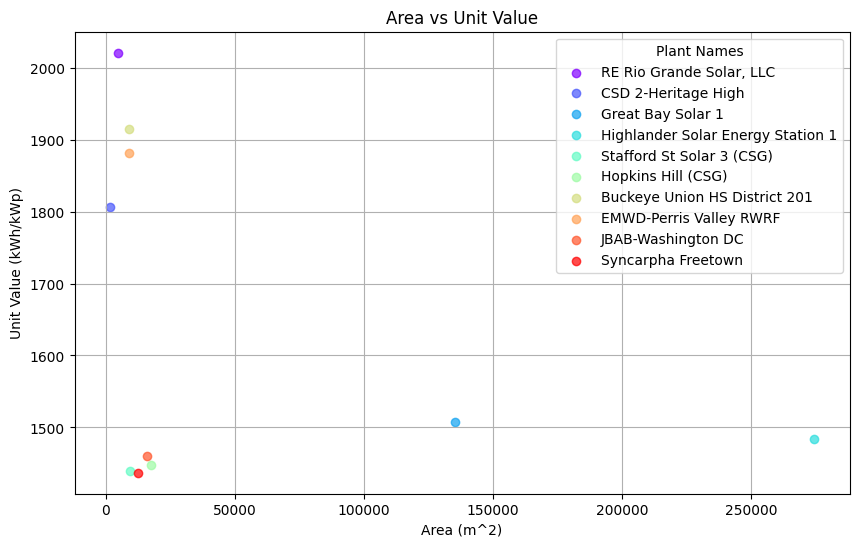

In [20]:
# Create a unique color for each name
unique_names = results_df['p_name'].unique()
colors = cm.rainbow(np.linspace(0, 1, len(unique_names)))
color_map = dict(zip(unique_names, colors))

# Create the scatter plot
plt.figure(figsize=(10, 6))

for name, color in color_map.items():
    subset = results_df[results_df['p_name'] == name]
    plt.scatter(subset['p_area'], subset['unit_value'], label=name, color=color, alpha=0.7)

plt.title('Area vs Unit Value')
plt.xlabel('Area (m^2)')
plt.ylabel('Unit Value (kWh/kWp)')
plt.legend(title='Plant Names')
plt.grid(True)
plt.show()


### Bar chart

- Unit value

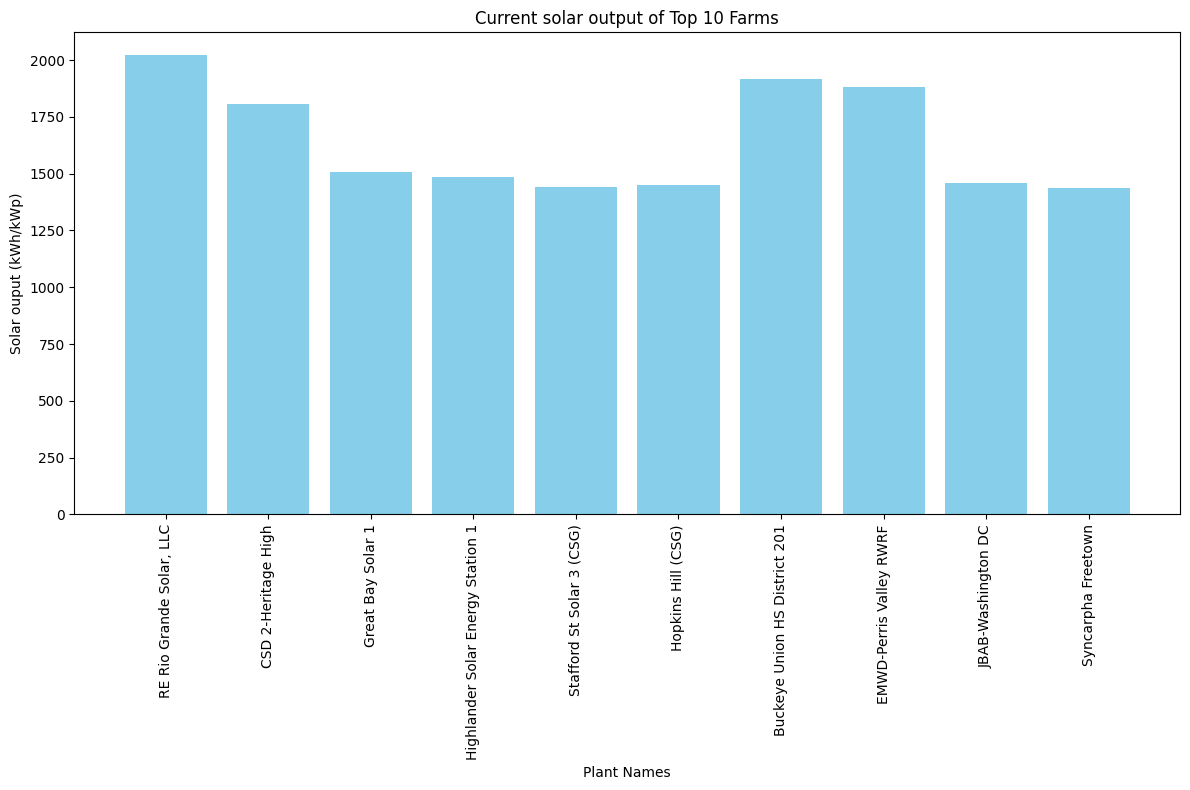

In [21]:
# Create bar chart
plt.figure(figsize=(12, 8))
plt.bar(results_df['p_name'], results_df['unit_value'], color='skyblue')
plt.xlabel('Plant Names')
plt.ylabel('Solar ouput (kWh/kWp)')
plt.title('Current solar output of Top 10 Farms')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- cap dc / area

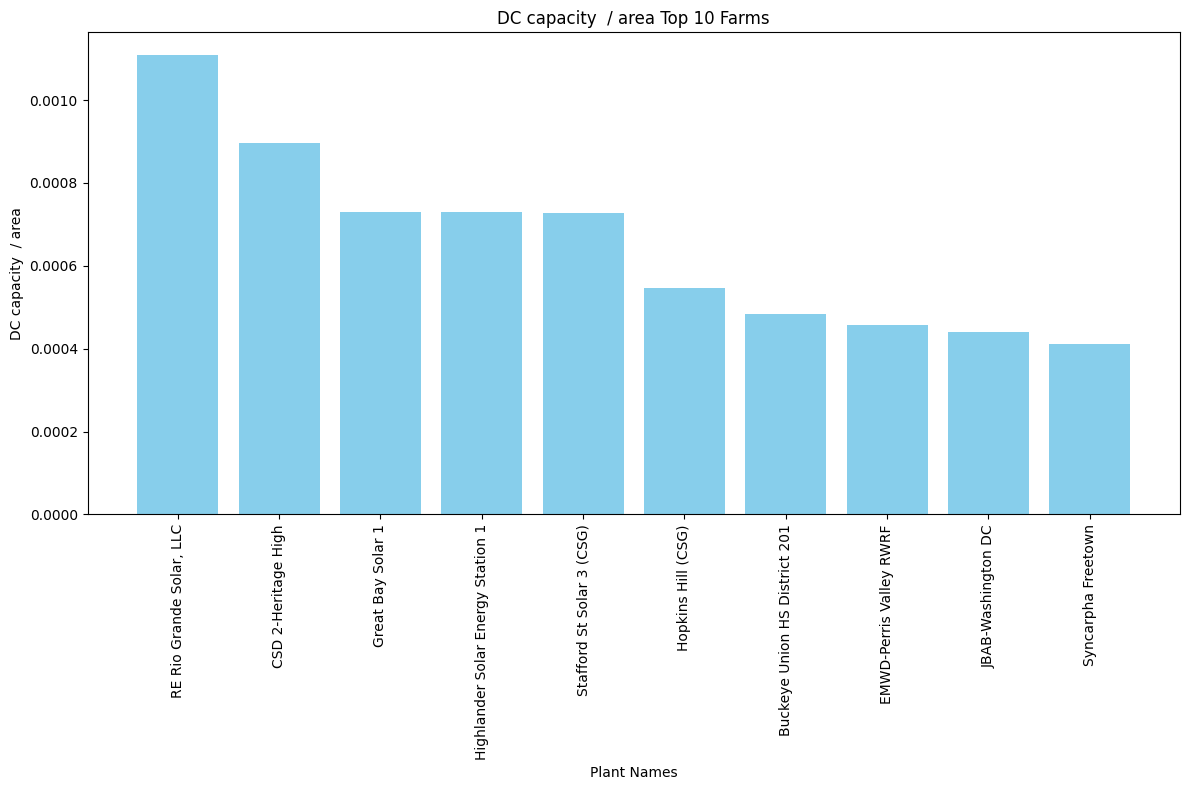

In [22]:
# Create bar chart
plt.figure(figsize=(12, 8))
plt.bar(results_df['p_name'], results_df['p_cap_dc'] / results_df['p_area'], color='skyblue')
plt.xlabel('Plant Names')
plt.ylabel('DC capacity  / area')
plt.title('DC capacity  / area Top 10 Farms')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()